In [1]:
import pandas as pd

In [48]:
data = pd.read_csv("C:\\campaign_data_2024.csv")

In [49]:
categorical_column = data['Gender'];
dummy_variables = pd.get_dummies(categorical_column, drop_first=True, prefix='Gender')
dummy_variables = dummy_variables.astype(int)
data = pd.concat([data.drop(columns=['Gender']), dummy_variables], axis=1)

In [32]:
data.describe()

,Unnamed: 0,Money,Recency,Frequency,Age,cat_Children,cat_Teen,cat_Cooking,cat_DIY,cat_Reference,cat_Art,Purchase_Secret_of_Italian_k,Purchase_italian_design,Purchase_Italian_Art,Buy,Gender_M
count,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,24999.500000,520.795800,11.567580,3.89022,40.002500,0.854460,0.390980,0.936600,0.463060,0.312240,0.385920,0.122100,0.037640,0.056040,0.090440,0.700360
std,14433.901067,253.393148,7.366277,3.47627,27.564683,1.120153,0.682996,1.185432,0.765877,0.603882,0.680261,0.327405,0.190326,0.230001,0.286814,0.458105
min,0.000000,37.500000,1.000000,1.00000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12499.750000,320.000000,7.000000,1.00000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24999.500000,522.500000,10.000000,2.00000,33.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,37499.250000,710.000000,14.000000,6.00000,54.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,49999.000000,1197.500000,32.000000,12.00000,148.000000,8.000000,6.000000,8.000000,7.000000,5.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [36]:
import sweetviz as sv

In [37]:
report = sv.analyze(data)
report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [51]:
X = data.drop(columns=['Gender_M'])
y = data['Buy']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [56]:
from sklearn.linear_model import LogisticRegression
reg_model = LogisticRegression(max_iter=1000)
reg_model.fit(X_train, y_train)
y_pred = reg_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred > 0.5).astype(int)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [113]:
import sklearn.metrics as metrics
probs = reg_model.predict_proba(X_test)
preds = probs[:, 1]
preds = (preds > 0.5).astype(int)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
auc = metrics.auc(fpr, tpr)

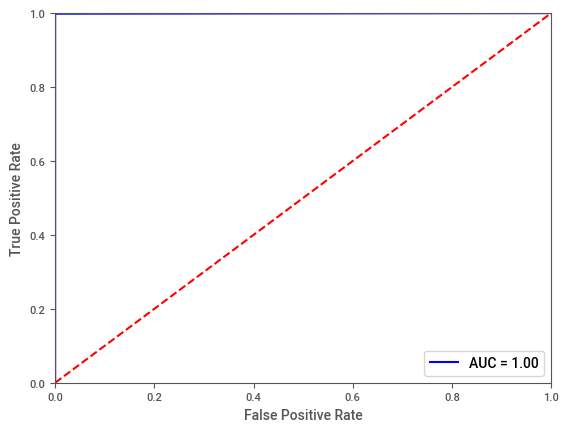

In [114]:
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [99]:
from sklearn.metrics import confusion_matrix
confusion_matrices = []
for thres in threshold:
    y_pred = (preds > thres).astype(int)
    confusion_matrices.append(confusion_matrix(y_test, y_pred))

In [100]:
def calculate_expected(confusion_matrix):
    tp, fp, fn, tn = confusion_matrix.ravel()
    profit = (tp * 100) - (fp * 12)
    return profit

In [101]:
expected_values =[calculate_expected(c) for c in confusion_matrices]

In [102]:
max_value = max(expected_values)
index = expected_values.index(max_value)
optimal_threshold = threshold[index]
optimal_matrix = confusion_matrices[index]
print("Optimal Confusion Matrix:")
print(optimal_matrix)

Optimal Confusion Matrix:
[[13677     0]
 [ 1323     0]]


In [124]:
validation_preds = preds
fpr_validation, tpr_validation,_ = metrics.roc_curve(y_test, validation_preds)
auc_validation = metrics.auc(fpr_validation, tpr_validation)
confusion_matrix_validation = confusion_matrix(y_test, validation_preds)
tn_validation, fp_validation, fn_validation, tp_validation = confusion_matrix_validation.ravel()
expected_value_validation = (tp_validation * 100) - (fp_validation * 12)
print("AUC on Validation File:", auc_validation)
print("confusion matrix on validation:", confusion_matrix_validation)
print("expected value validation :",expected_value_validation)

AUC on Validation File: 0.999244142101285
confusion matrix on validation: [[13677     0]
 [    2  1321]]
expected value validation : 132100


In [128]:
train_preds = reg_model.predict_proba(X_train)[:, 1]
train_preds = (train_preds > 0.5).astype(int)
fpr_train, tpr_train, threshold_train = metrics.roc_curve(y_train, train_preds)
train_auc = metrics.auc(fpr_train, tpr_train)
confusion_matrix_train = confusion_matrix(y_train,train_preds)
tn_train, fp_train, fn_train, tp_train = confusion_matrix_train.ravel()
expected_value_train = (tp_train * 100) - (fp_train * 12)
print("AUC on Training :",train_auc)
print("confusion matrix on Training:",confusion_matrix_train)
print("expected value Training :",expected_value_train)

AUC on Training : 0.9998437011566115
confusion matrix on Training: [[31801     0]
 [    1  3198]]
expected value Training : 319800


In [127]:
accuracy_train = (tp_train +tn_train) / (tp_train + fp_train + tn_train + fn_train)
precision_train = tp_train / (tp_train + fp_train)
recall_train = tp_train / (tp_train + fn_train)
f1_score_train = 2 * (precision_train * recall_train) / (precision_train + recall_train)
print("Accuracy train:", accuracy_train)
print("Precision train:", precision_train)
print("Recall train:", recall_train)
print("F1-Score train:", f1_score_train)
accuracy_validation = (tp_validation +tn_validation) / (tp_validation + fp_validation + tn_validation + fn_validation)
precision_train = tp_validation / (tp_validation + fp_validation)
recall_train = tp_validation / (tp_validation + fn_validation)
f1_score_train = 2 * (precision_validation * recall_validation) / (precision_validation + recall_validation)
print("Accuracy validation:", accuracy_validation)
print("Precision validation:", precision_validation)
print("Recall validation:", recall_validation)
print("F1-Score validation:", f1_score_validation)

Accuracy train: 0.9999714285714286
Precision train: 1.0
Recall train: 0.9996874023132228
F1-Score train: 0.9998436767234641
Accuracy validation: 0.9998666666666667
Precision validation: 1.0
Recall validation: 0.99848828420257
F1-Score validation: 0.9992435703479576


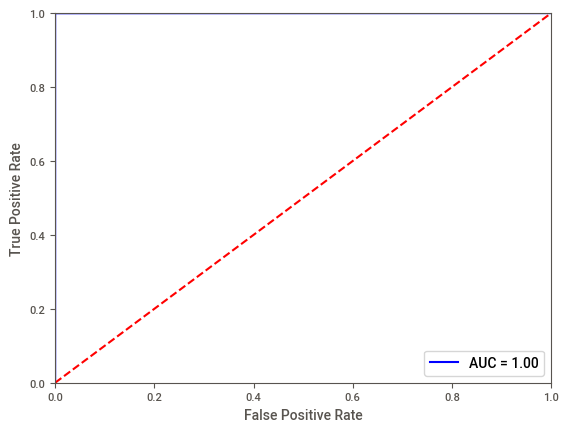

In [130]:
plt.plot(fpr_train, tpr_train, 'b', label = 'AUC = %0.2f' % train_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()